# Predicting the House Price of a Home in Ames, Iowa

##  Problem Statement

[Home appraisals](https://www.investopedia.com/articles/pf/12/home-appraisals.asp) are almost always used in home purchase and sale transactions as well as in mortgage refinancing. Appraisers within a given financial institution will utilize the same [checklist](https://www.americanfinancing.net/mortgage-basics/home-appraisal-checklist) for conducting home value comparisons in a given area. This project aims to use linear regression to aid home appraisers in Ames, Iowa determine an accurate home value based on responses to the appraisal checklist used in the Ames, Iowa Housing dataset. 

## Contents

## Background


## Data



## Data Cleaning and EDA

My objective for this portion of the modeling is to transform the Ames Housing dataset into a dataset useful for linear regression modeling. 

The work-flow is as follows:
* Impute for my null values in each feature
* Determine whether my predictors have a linear relationship to sale price 
* Transform ordinal and categorical predictors
* Identify outliers that can be dropped or cleaned if it is a transcription error

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


from sklearn import metrics
from statsmodels.formula.api import ols
from scipy import stats

# pd.set_option('display.max_columns', 999)
# pd.set_option('display.max_rows', 999)

In [2]:
# Reading the training dataset into dataframe train
train = pd.read_csv('datasets/train.csv')

In [3]:
# Cleaning the name of the train column headers
for col in train.columns:
    train.rename(columns={col: col.lower().replace(' ','_')}, inplace=True)

In [4]:
# Checking which datasets columns are null

train.isnull().sum().sort_values(ascending=False).head(n=27)

pool_qc           2042
misc_feature      1986
alley             1911
fence             1651
fireplace_qu      1000
lot_frontage       330
garage_finish      114
garage_cond        114
garage_qual        114
garage_yr_blt      114
garage_type        113
bsmt_exposure       58
bsmtfin_type_2      56
bsmtfin_type_1      55
bsmt_cond           55
bsmt_qual           55
mas_vnr_type        22
mas_vnr_area        22
bsmt_half_bath       2
bsmt_full_bath       2
garage_cars          1
garage_area          1
bsmt_unf_sf          1
bsmtfin_sf_2         1
total_bsmt_sf        1
bsmtfin_sf_1         1
overall_cond         0
dtype: int64

## Explanation of Values Imputed for Null Values 

* garage_year_built is the only numerical feature whose null values I did not impute with 0. Instead, I imputed the value with the mean year built because the sale price for null values followed the same distribution that the null values for non-null values. 
* Other null numerical features suggests that feature does not exist for the observation. For example, a null fireplace_qu value denotes that the home sold does not have a fireplace. 

|Feature with Null Value|What Null Value Means|Imputed Value|
| --- | --- | --- |
|pool_qc| No pool| 0|
|misc feature|No misc. features|Na|
|alley|No alley acess|Na|
|fireplace_qu|No fireplace|0|
|lot_frontage|House not on street|0|
|garage_cars|No garage|0|
|garage_area|No garage|0|
|garage_finish|No garage|Na|
|garage_cond|No garage|0|
|garage_qual|No garage|0|
|garage_yr_blt|No garage|Garage year built median|
|garage_type|No garage|Na|
|bsmt_exposure|No basement|Na|
|bsmtfin_type_2|No basement|Na|
|bsmtfin_type_1|No basement|Na|
|bsmt_cond|No basement|0|
|bsmt_qual|No basement|0|
|bsmt_half_bath|No basement|0|
|bsmt_full_bath|No basement|0|
|bsmt_unf_sf|No basement|0|
|bsmtfin_sf_2|No basement|0|
|total_bsmt_sf|No basement|0|
|bsmtfin_sf_1|No basement|0|
|mas_vnr_type|No veneer|Na|
|mas_vnr_area|No veneer|0|


### Numerical Features

Features that inherently discrete measurements of a particular home attribute. 

In [5]:
# Dropping target and numerical columns that are not continuous variables 

drop_cols = ['ms_subclass', 'id', 'pid', 'saleprice']
numerical_columns = train._get_numeric_data().columns.drop(drop_cols)


In [6]:
# Imputing null values with median value because there is a significant outlier 
# in the garage year built that pulls the mean higher. The median is actually 
# the more accurate measure of central tendency because of this. 

train['garage_yr_blt'].fillna(train['garage_yr_blt'].median(), inplace=True)

In [7]:
# Imputing all other numerical nulls with 0 

train[numerical_columns] = train[numerical_columns].fillna(0)

In [8]:
# Calculating Fisher-Pearson coefficient of skewness for each feature 

skewness = pd.DataFrame({'feature': numerical_columns})
skewness['skewness'] = stats.skew(train[numerical_columns])

In [9]:
# Utilizing Fisher-Pearson coefficients to label the feature based on its 
# distribution. 

# Fisher-Pearson coefficient > 10
high_right_skew = skewness[skewness['skewness'] >= 10]['feature'].to_list()

# Fisher-Pearson coefficient < 10 and > 1
moderate_skew = (skewness['skewness'] < 10) & (skewness['skewness'] >= 1)
moderate_right_skew = skewness[moderate_skew]['feature'].to_list()

# Fisher-Pearson coefficient < 1

normal = skewness[skewness['skewness'] < 1]['feature'].to_list()

### Distribution of Predictors

#### Normally distributed dependent variables

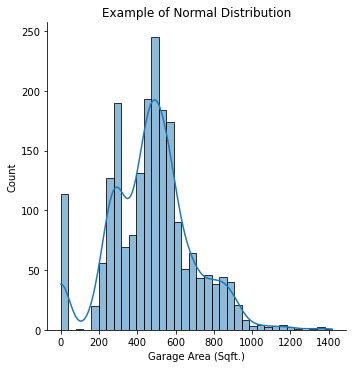

In [10]:
sns.displot(data=train, x ='garage_area', kde=True)
plt.xlabel('Garage Area (Sqft.)')
plt.title('Example of Normal Distribution');

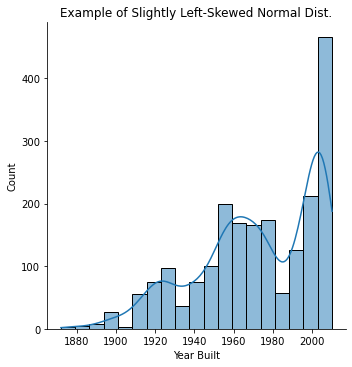

In [11]:
sns.displot(data=train, x = 'year_built', kde=True)
plt.xlabel('Year Built')
plt.title('Example of Slightly Left-Skewed Normal Dist.');

In [12]:
print('Normally Distributed Predictors:\n')
for feature in normal:
    print(feature)

Normally Distributed Predictors:

lot_frontage
overall_qual
overall_cond
year_built
year_remod/add
bsmt_unf_sf
2nd_flr_sf
bsmt_full_bath
full_bath
half_bath
bedroom_abvgr
totrms_abvgrd
fireplaces
garage_yr_blt
garage_cars
garage_area
mo_sold
yr_sold


#### Moderately skewed to the right 

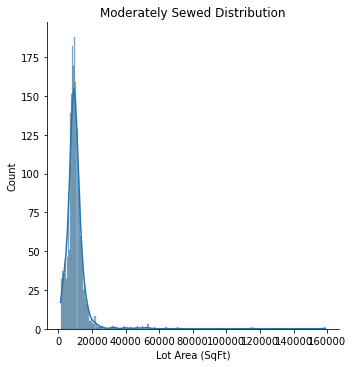

In [13]:
sns.displot(data=train, x='lot_area', kde=True)
plt.xlabel('Lot Area (SqFt)')
plt.title('Moderately Sewed Distribution');

In [14]:
print('Moderately Skewed Predictors:\n')
for feature in moderate_right_skew:
    print(feature)

Moderately Skewed Predictors:

lot_area
mas_vnr_area
bsmtfin_sf_1
bsmtfin_sf_2
total_bsmt_sf
1st_flr_sf
gr_liv_area
bsmt_half_bath
kitchen_abvgr
wood_deck_sf
open_porch_sf
enclosed_porch
screen_porch


#### Highly skewed to the right

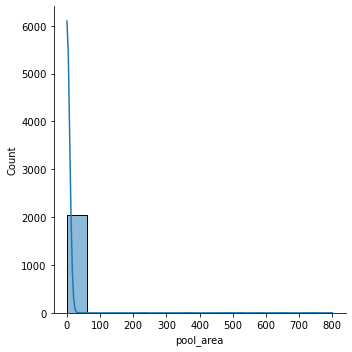

In [15]:
sns.displot(data=train, x='pool_area', kde=True);

In [16]:
print('Highly Skewed Predictors:\n')
for feature in high_right_skew:
    print(feature)

Highly Skewed Predictors:

low_qual_fin_sf
3ssn_porch
pool_area
misc_val


#### Distribution Analysis

There are several predictors whose values are highly skewed to the right, which will make our predictions for higher prices less accurate than for the lower prices. The values within the higher density count regions will have more errors to account for, which will ultimately make the regression more predictive than the outlier values. Therefore, the highly skewed predictors may not be useful for linear regression.

### Predictor Relationship to Sale Price 

In [17]:
# Source: https://stackoverflow.com/questions/60124004/creating-dataframe-on-the-basis-of-r-squared-value

# Dataframe of r2 values for each feature with regard to sale price

r2_values = pd.DataFrame({'features': numerical_columns,
            'r2':[
            stats.linregress(train[[col,'saleprice']].to_numpy()).rvalue ** 2 
            for col in numerical_columns
                 ]
                         })

display(r2_values)

,features,r2
0,lot_frontage,0.032926
1,lot_area,0.087951
2,overall_qual,0.640331
3,overall_cond,0.009413
4,year_built,0.327011
5,year_remod/add,0.302907
6,mas_vnr_area,0.253591
7,bsmtfin_sf_1,0.179654
8,bsmtfin_sf_2,0.000270
9,bsmt_unf_sf,0.036428


In [18]:
train['log_saleprice'] = train['saleprice'].map(np.log)

#### R2 Values improve when saleprice is power transformed

In [19]:
# Assessing whether a power transformation of sale price improves the relationships
# to its numerical features. 
log_r2_values = pd.DataFrame({'features': numerical_columns,
            'r2':[
            stats.linregress(train[[col,'log_saleprice']].to_numpy()).rvalue ** 2 
            for col in numerical_columns
                 ]
                         })

display(log_r2_values)


,features,r2
0,lot_frontage,2.108248e-02
1,lot_area,7.836740e-02
2,overall_qual,6.769574e-01
3,overall_cond,1.376225e-03
4,year_built,3.899362e-01
5,year_remod/add,3.593505e-01
6,mas_vnr_area,1.958171e-01
7,bsmtfin_sf_1,1.675732e-01
8,bsmtfin_sf_2,7.169991e-04
9,bsmt_unf_sf,3.795982e-02


#### R2 Value Greater than 0.6

<Figure size 648x648 with 0 Axes>

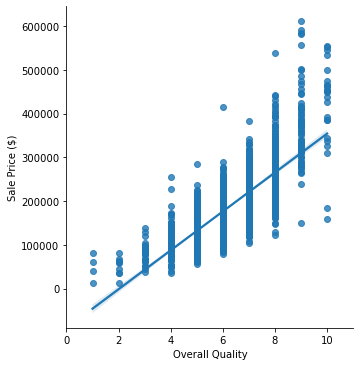

<Figure size 648x648 with 0 Axes>

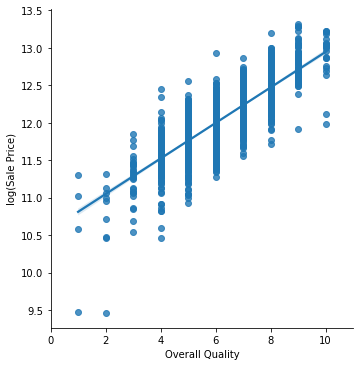

In [20]:
plt.figure(figsize=(9,9))
sns.lmplot(data=train, x='overall_qual', y='saleprice')
plt.xlim(0,11)
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price ($)');

plt.figure(figsize=(9,9))
sns.lmplot(data=train, x='overall_qual', y='log_saleprice')
plt.xlim(0,11)
plt.xlabel('Overall Quality')
plt.ylabel('log(Sale Price)');

#### R2 Between  0.4 and 0.5

<Figure size 648x648 with 0 Axes>

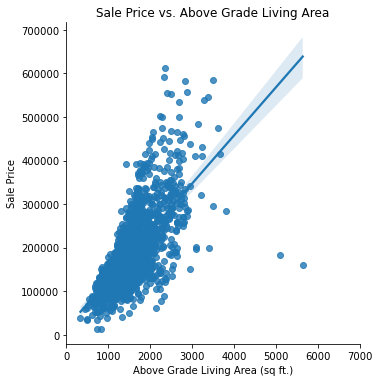

<Figure size 648x648 with 0 Axes>

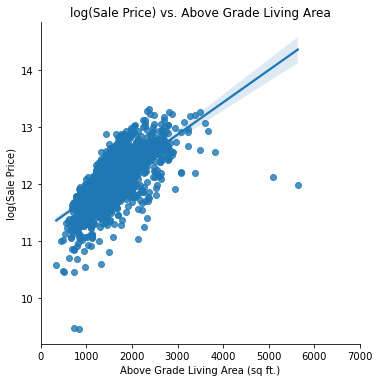

In [21]:
plt.figure(figsize=(9,9))
sns.lmplot(data=train, x='gr_liv_area', y='saleprice')
plt.xlim(0, 7000)
plt.ylabel('Sale Price')
plt.xlabel('Above Grade Living Area (sq ft.)')
plt.title('Sale Price vs. Above Grade Living Area');
           
plt.figure(figsize=(9,9))
sns.lmplot(data=train, x='gr_liv_area', y='log_saleprice')
plt.xlim(0, 7000)
plt.ylabel('log(Sale Price)')
plt.title('log(Sale Price) vs. Above Grade Living Area')
plt.xlabel('Above Grade Living Area (sq ft.)');

#### R2 Between 0.3 and 0.4

<Figure size 648x648 with 0 Axes>

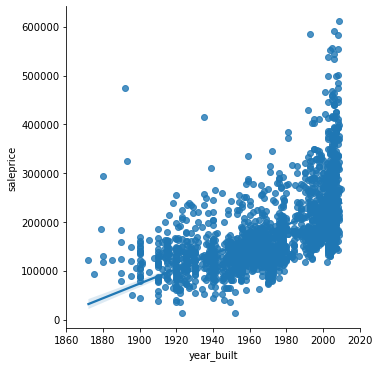

<Figure size 648x648 with 0 Axes>

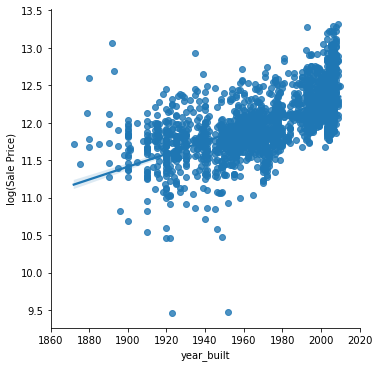

In [22]:
plt.figure(figsize=(9,9))

sns.lmplot(data=train, x='year_built', y='saleprice')
plt.xlim(1860, 2020);

plt.figure(figsize=(9,9))
sns.lmplot(data=train, x='year_built', y='log_saleprice')
plt.ylabel('log(Sale Price)')
plt.xlim(1860, 2020);

#### R2 Between 0.2 and 0.3

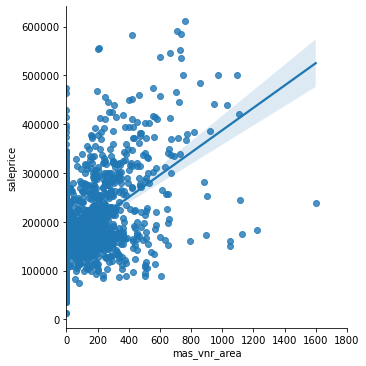

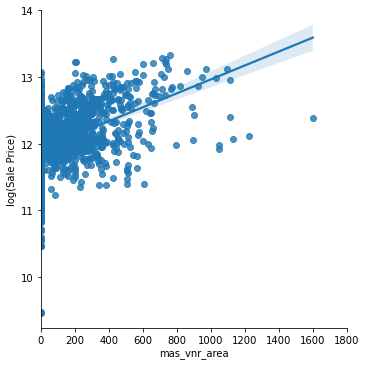

In [23]:
sns.lmplot(data=train, x='mas_vnr_area', y='saleprice')
plt.xlim(0, 1800);

sns.lmplot(data=train, x='mas_vnr_area', y='log_saleprice')
plt.xlim(0, 1800)
plt.ylabel('log(Sale Price)');

#### R2 between 0 and 0.10

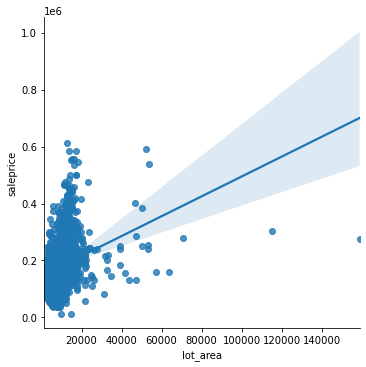

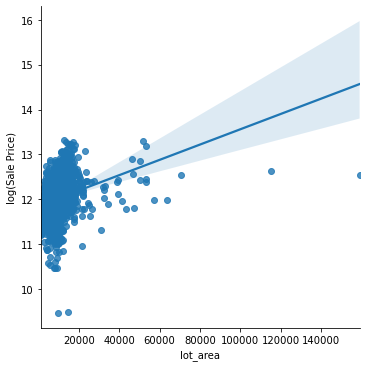

In [24]:
sns.lmplot(data=train, x='lot_area', y='saleprice');
#plt.xlim(0, 1800)

sns.lmplot(data=train, x='lot_area', y='log_saleprice')
#plt.xlim(0, 1800)
plt.ylabel('log(Sale Price)');

### Relationship Analysis

* Power transformation of Sale Price makes model slightly more accurate 
* 95% Confidence interval gets much larger with more outliers, proving that features with outliers will have a lower prediction accuracy 
    * Power transformaion narrows the 95% Confidence Interval for each feature


### Numerical Predictor Summary Statistics

In [25]:
train[numerical_columns].describe()

,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,...,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,...,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,57.944417,10065.208191,6.112140,5.562165,1971.708922,1984.190151,98.626524,442.084837,47.935641,567.451487,...,473.440761,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719
std,33.137332,6742.488909,1.426271,1.104497,30.177889,21.036250,174.324690,461.195041,164.964052,445.022846,...,216.135102,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014
min,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,43.500000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,...,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,63.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.000000,...,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,78.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,159.000000,733.500000,0.000000,811.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000


### Categorical and Ordinal Feature Cleaning

#### Ordinal Features

In [26]:
# Filtering train for all categorical and ordinal columns (non-numerical datatypes)

string_feats = train.select_dtypes(object)

Inspiration for ordinal feature filtering came from this [source](https://stackoverflow.com/questions/56704700/select-columns-if-any-of-their-rows-contain-a-certain-string)

In [27]:
# Selecting ordinal features: features that are categorical but have a clear ordering
# Ordinal features have substring 'Ex' to denote highest score, so we can find \
# ordinal values based on whether the column has a tring that contains 'Ex'

ordinal_filter = string_feats.applymap(lambda x: 'Ex' in str(x)).any()
ordinal_columns = string_feats.columns[ordinal_filter].to_list()
ordinal_columns

['exter_qual',
 'exter_cond',
 'bsmt_qual',
 'bsmt_cond',
 'heating_qc',
 'kitchen_qual',
 'fireplace_qu',
 'garage_qual',
 'garage_cond',
 'pool_qc']

In [28]:
# Mapping quantitative scale to ordinal values

qual_to_quant_scale = {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po': 1}

train[ordinal_columns] = train[ordinal_columns].applymap(qual_to_quant_scale.get)

In [29]:
log_r2_ordinal_values = pd.DataFrame({'features': ordinal_columns,
            'r2':[
            stats.linregress(train[[col,'log_saleprice']].to_numpy()).rvalue ** 2 
            for col in ordinal_columns
                 ]
                         })
# r2_values['r2'] = stats.linregress(train[[numerical_columns, 'saleprice']].to_numpy()).rvalue ** 2
display(log_r2_ordinal_values)


,features,r2
0,exter_qual,0.476560
1,exter_cond,0.007584
2,bsmt_qual,NaN
3,bsmt_cond,NaN
4,heating_qc,0.251938
5,kitchen_qual,0.464511
6,fireplace_qu,NaN
7,garage_qual,NaN
8,garage_cond,NaN
9,pool_qc,NaN


In [30]:
# Imputing ordinal null values with 0. Null values denote the feature does not exist, so I \
# substitute in 0 for the ordinal scale (below poor).

train[ordinal_columns] = train[ordinal_columns].fillna(0)

#### Strong Ordinal Relationship to Sale Price

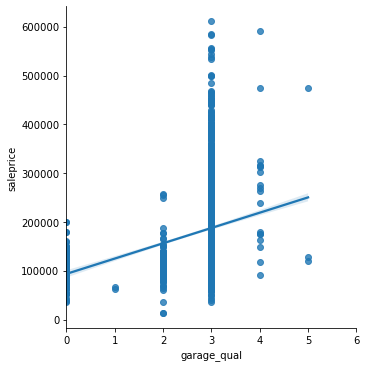

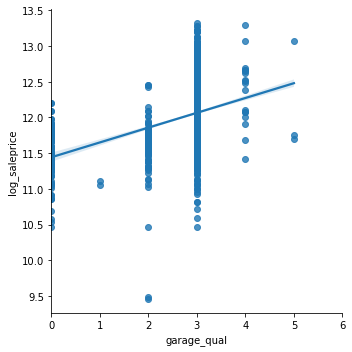

In [31]:
# for col in ordinal_columns[:-1]:
    
#     #fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

#     #print(n_row,n_column)   
sns.lmplot(data=train, x='garage_qual', y='saleprice')
plt.xticks([0,1,2,3,4,5,6])
sns.lmplot(data=train, x='garage_qual', y='log_saleprice')
plt.xticks([0,1,2,3,4,5,6])
#plt.xlim()
    #axes[n_row,n_column].scatter(train[col], train['saleprice'])
    
#     n_column += 1
#     if n_column == 2:
#         n_row += 1
#         n_column = 0
        
plt.tight_layout()

#### Weak Ordinal Relationship to Sale Price 

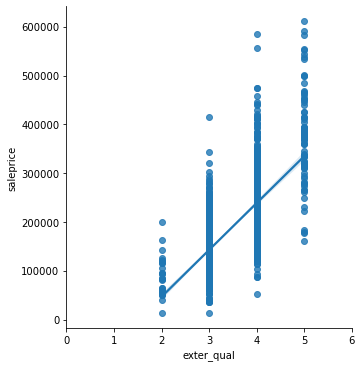

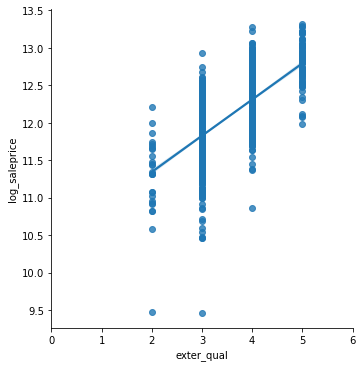

In [32]:
sns.lmplot(data=train, x='exter_qual', y='saleprice')
plt.xticks([0,1,2,3,4,5,6])
sns.lmplot(data=train, x='exter_qual', y='log_saleprice')
plt.xticks([0,1,2,3,4,5,6]);

#### Categorical Features

In [33]:
# Categorical datatypes are object datatypes minus the ordinal columns

categorical_columns = string_feats.drop(ordinal_columns, axis=1).columns.to_list()

In [34]:
# There is one column that is an integer datatype that is actually a categorical variable: ms_subclass
# The integers in this column denote a particular building class rather than a continuous value

categorical_columns.append('ms_subclass')

In [35]:
# Filling categorical feature null values with 'Na'
# Allows me to identify and drop nulls in Creation of dummy columns

train[categorical_columns] = train[categorical_columns].fillna('Na')

#### One-hot encoding categorical features

In order to utilize the categorical data, it needs to be transformed into 
meaningful numerical information. To do this, I will one hot encode the categorical 
data through a two-step masking process. 

* In the first step, I will analyze whether the value for a given feature has enough meaningful data points to ensure that I will not be introducing unnecessary variance into my linear regression. I set the threshold for this at 100 total observations per value. 
* In the second step, I created 4 distinct sale price bins that allowed me to filter each value based on its mean sale price. By doing so, I was able to create some insight into how that particular value influences the sale price of a house. I then ensured that I did not create an empty dummy column in order to maintain the efficiency of my dummy columns. 

I maintained rank efficiency through this two-step process, ensuring that there was always at least one value from each feature that would not be found in any of the created dummy columns.

In [36]:
def one_hot_encode(column_list):
    
    '''One hot encodes categorical features into 5 possible bins: one of the 
    150k, 200k, 250k, 300k sale bins or the dropped bin which includes values
    with not enough features to be included in one of the sale price bins. 
    ---
    Parameter:
    column_list: list of categorical columns to be one-hot encoded.'''
    
    # List of dummy columns created 
    dummy_columns = []
    columns_dummied = []
    
    for col in column_list:
    # Creates series of values in column with their sale price
        col_groupby = train.groupby(col)['saleprice']
        col_count_mean = col_groupby.agg(['count', 'mean'])
        
        
        # Drop null values from the value counts
        if 'Na' in col_count_mean.index.to_list():
            col_count_mean.drop('Na', inplace=True)
    
        
        # Ensures that sparse values are not included 
        col_counts = col_count_mean['count'] > 100
        if len(col_count_mean[col_counts]) < 2:
            continue
            
        
        # Sale price binning for each feature 
        # The price associated with the first 3 bins denotes the price to 
        # which the bin goes up to, wheras the last bin represents the values 
        # that round to 300k
        col_price_150k = col_count_mean['mean'] <= 150_000
        
        col_price_200k = ((col_count_mean['mean'] > 150_000) & 
                                (col_count_mean['mean'] <= 200_000))
        
        col_price_250k = ((col_count_mean['mean'] > 200_000) & 
                                (col_count_mean['mean'] <= 250_000))
        
        col_price_300k = col_count_mean['mean'] > 250_000
        
        
        # List of values in each feature that meet sale price conditions and count values
        col_150k_values = col_count_mean[(col_counts) & 
                                         (col_price_150k)].index.to_list()
        
        col_200k_values = col_count_mean[(col_counts) & 
                                         (col_price_200k)].index.to_list()
        
        col_250k_values = col_count_mean[(col_counts) & 
                                         (col_price_250k)].index.to_list()
        
        col_300k_values = col_count_mean[(col_counts) & 
                                         (col_price_300k)].index.to_list()
        
        
        # Masking train for dummy column creation
        col_150k_mask = train[col].isin(col_150k_values)
        col_200k_mask = train[col].isin(col_200k_values)
        col_250k_mask = train[col].isin(col_250k_values)
        col_300k_mask = train[col].isin(col_300k_values)
        
        # Getting base column name for dummy column creation 
        column_name = f'{col}'
        columns_dummied.append(column_name)
        
        columns_created = []
        
        # Creating dummy columns
        if sum(col_150k_mask) > 0:
            train[column_name + '_150k'] = col_150k_mask.astype(int)
            columns_created.append(column_name + '_150k')
        if sum(col_200k_mask) > 0:
            train[(column_name + '_200k')] = col_200k_mask.astype(int)
            columns_created.append(column_name + '_200k')
        if sum(col_250k_mask) > 0:
            train[(column_name + '_250k')] = col_250k_mask.astype(int)
            columns_created.append(column_name + '_250k')
        if sum(col_300k_mask) > 0:
            train[(column_name + '_300k')] = col_300k_mask.astype(int)
            columns_created.append(column_name + '_300k')
            
        
        # Filling null values with 0 
        train.loc[:, columns_created] = train[columns_created].fillna(0)
        
        # Adding dummy columns to dummy_column list
        dummy_columns += columns_created
        
    return (columns_dummied, dummy_columns)

categorical_cols = one_hot_encode(categorical_columns)

#### Validity of this Approach

To graphically show the validity of this approach, I plotted 7 neighborhood average selling prices. Amongst the neighborhoods chosen, the neighborhoods could fall in one of three bins: the up to 150k bin, the up to 250k  bin, or the dropped bin because the neighborhood does not have enough homes to make it past the observational threshold.

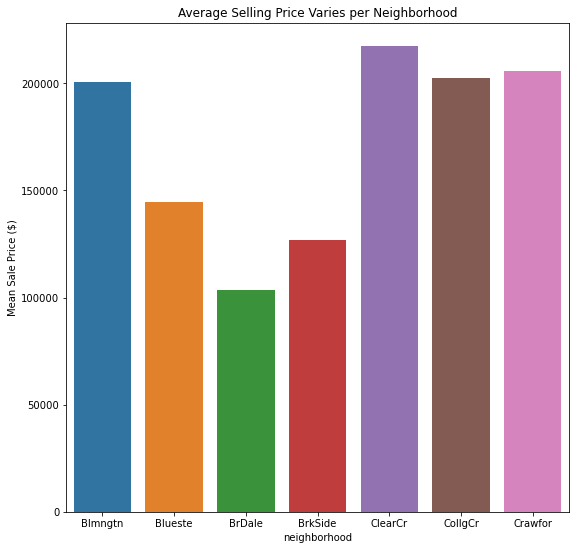

In [37]:

neighborhood_gb = train.groupby('neighborhood')['saleprice']
neighborhood_count_mean = neighborhood_gb.agg(['count','mean'])[:7]

plt.figure(figsize=(9,9))
sns.barplot(data=neighborhood_count_mean, x=neighborhood_count_mean.index, y='mean')
plt.ylabel('Mean Sale Price ($)')
plt.title('Average Selling Price Varies per Neighborhood');

In [38]:
# https://seaborn.pydata.org/tutorial/categorical.html
# sns.catplot(x=categorical_cols[0][0], y='saleprice', data=train)

In [39]:
# sns.displot(data=train, x='neighborhood_100k')
# sns.displot(data=train, x='neighborhood_200k')
# sns.displot(data=train, x='neighborhood_300k')

In [40]:

#sns.pairplot(data=train, x_vars=one_hot_encode(categorical_columns), y_vars='saleprice')
#len(one_hot_encode(categorical_columns))
# n_row = 0
# n_column=0
# fig, ax = plt.subplots(7,3, figsize=(12,12))
# for col in dummy_categorical_cols:
    
#     ax[n_row,n_column].hist(x=train[col])
    
#     n_column += 1
#     if n_column == 3:
#         n_row += 1
#         n_column = 0
        
# plt.tight_layout()

In [41]:
# grouby neighborhood, display count of each instance of the neighborhood. Display, the average price
# bucket into separate category and drop sparse values from regression 
#plt.figure(figsize=(10,10))
# neighborhood_gb = train.groupby('neighborhood')['saleprice']
# neighborhood_count_mean = neighborhood_gb.agg(['count','mean'])

#sns.histplot(x=neighborhood_count_mean.index)
#sns.barplot(data=neigh_mask, x=neigh_mask.index, y='mean', hue='count');

In [42]:
# neigh_count_values = neighborhood_count_mean[neighborhood_count_mean['count'] > 100]
# neigh_150k_values = neighborhood_count_mean['mean'] < 150_000
# neigh_150k_250k_values = (neighborhood_count_mean['mean'] >= 150_000) & (neighborhood_count_mean['mean'] < 250_000)
# neigh_250k_values = neighborhood_count_mean['mean'] >= 250_000

In [43]:
# # Bin 1 consists of neighborhoods with > 100 houses and < 150K mean price
# neighborhood_bin_1 = train['neighborhood'].isin(neighborhood_150k_values)

### Outlier Identification 

* Outliers are identified with leveraged (AKA studentized) residuals post linear regression modeling. 
    * [Source: Introduction to Statistical Learning, pg 97](https://statlearning.com/ISLR%20Seventh%20Printing.pdf)
* The below figure displays studentized residuals vs the total predicted price. 
* There are 5 total outliers: points with studentized residuals greater than 6 or less than -6.
* The code for calculating outliers is shown below

### Code that calculated studentized residuals

```
# Predictors span the entire set of observations 
X_train_sm = sm.add_constant(X, prepend=True)

# Instantiating and fitting statsmodels ordinary least squares
lr_model = sm.OLS(y_log, X_train_sm).fit()

```
```
# Performing statsmodels outliers test, calculates leveraged (AKA studentized) residuals
outliers = lr_model.outlier_test()

# Gathering 5 largest outliers according to leveraged residuals
outliers['student_resid'].abs().sort_values(ascending=False).head(n=5)

# Calculating predicted prices for ordinary least squares
sm_pred_prices = np.exp(lr_model.predict(X_train_sm))
```

```
# Plotting leveraged residuals versus the predicted prices
student_res = outliers['student_resid']

# Most data points concentrated between -6 and 6 studentized residuals
# Outliers are thus greater than 6 or less than -5
plt.axhline(y=-6, color='red')
plt.axhline(y=6, color='red')
plt.scatter(x=sm_pred_prices, y=student_res)

plt.title('Outlier Identification')
plt.ylabel('Studentized Residuals')
plt.xlabel('Predicted Price')

plt.savefig('./figures/outlier_identification.png', format='png');
```
|Index|Studentized Residual(abs value)|
|---|---|
|960|16.898|
|1628|11.360|
|183|10.625|
|1885|10.481|
|952|6.635|

![Outliers](./figures/outlier_identification.png)

In [44]:
# Dropping outliers
train.drop([960,1628,183,1885, 952], inplace=True)

In [45]:
# This garage year built does not make sense (2207). 
# Replacing it with the median value

train[train['garage_yr_blt'] == train['garage_yr_blt'].max()]
train.loc[1699, 'garage_yr_blt'] = train['garage_yr_blt'].median()

In [46]:
# Saving the clean training data to my outputs

train.to_csv('./output/train_clean.csv', index=False)

## Ability to Address Problem Statement

The thoroughness of the Ames Housing dataset allows me to construct numerical data to perform linear regression modeling. While 43 of the features are categorical by nature, I was able to transform these columns into meaningful data points utilizing one hot encoding and hierarchical data into an ordinal ranking. The next steps involve feature ranking, multicollinearity testing, and regularization in order to develop the most accurate model.